# Inventory Optimization Under Demand Uncertainty: A Newsvendor and Monte Carlo Analysis

This analysis applies the newsvendor framework and Monte Carlo simulation to optimize daily pizza dough production under uncertain demand. By modeling the tradeoff between stockouts and excess inventory, the project identifies the production policy that maximizes expected annual profit while maintaining strong service performance.

## Import Libraries

In [ ]:
# Import relevant python libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.stats import f_oneway, kruskal
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os
import newsvendor_simulation as nv

## Load Dataset

In [ ]:
# Load dataset.
df = pd.read_csv("pizza_sales.csv")

## Data Preprocessing

In [ ]:
# Convert relevant columns to integer data type.
df[["pizza_id", "order_id", "quantity"]] = df[["pizza_id", "order_id", "quantity"]].astype(int)

# Combine date and time columns into a single datetime column.
df["order_date"] = pd.to_datetime(df["order_date"], errors='coerce', format='mixed')
df["order_time"] = pd.to_datetime(df["order_time"], format='%H:%M:%S').dt.time
df["order_datetime"] = df["order_date"].astype(str) + " " + df["order_time"].astype(str)
df["order_datetime"] = pd.to_datetime(df["order_datetime"], errors='coerce')

# Create a new column for the day of the week.
df["weekday"] = df["order_datetime"].dt.day_name()
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["weekday"] = pd.Categorical(df["weekday"], categories=weekday_order, ordered=True)
weekday_cat_dtype = pd.CategoricalDtype(categories=weekday_order, ordered=True)

# Create an orderd list of pizza sizes and convert "pizza_size" to an categorical variable.
size_order = ["S", "M", "L", "XL", "XXL"]
df["pizza_size"] = pd.Categorical(df["pizza_size"], categories=size_order, ordered=True)

# Set datetime column as index and sort the dataframe by datetime.
df = df.set_index("order_datetime").sort_index()

## Exploratory Data Analysis

### Descriptive Statistics

In [ ]:
# Display basic information about the dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48620 entries, 2015-01-01 11:38:36 to 2015-12-31 23:02:05
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pizza_id           48620 non-null  int64         
 1   order_id           48620 non-null  int64         
 2   pizza_name_id      48620 non-null  object        
 3   quantity           48620 non-null  int64         
 4   order_date         48620 non-null  datetime64[ns]
 5   order_time         48620 non-null  object        
 6   unit_price         48620 non-null  float64       
 7   total_price        48620 non-null  float64       
 8   pizza_size         48620 non-null  category      
 9   pizza_category     48620 non-null  object        
 10  pizza_ingredients  48620 non-null  object        
 11  pizza_name         48620 non-null  object        
 12  weekday            48620 non-null  category      
dtypes: category(2), datetime64

In [ ]:
# Check the shape of the dataframe.
print(f'Rows: {df.shape[0]}, Columns: {df.shape[1]}')

Rows: 48620, Columns: 13


In [ ]:
# Get the number of days in 2015.
print(f'Days in 2015: {len(pd.date_range(start="2015-01-01", end="2015-12-31"))}')

# Get the number of unique order dates in the dataset.
print(f'Days where orders were placed: {df["order_date"].nunique()}')

# Identify dates with no orders.
all_dates = pd.date_range(start="2015-01-01", end="2015-12-31")
order_dates = df["order_date"].unique()
no_order_dates = all_dates.difference(order_dates)
no_order_dates = [date.strftime('%Y-%m-%d') for date in no_order_dates]
print(f'Dates with no orders: {no_order_dates}')

Days in 2015: 365
Days where orders were placed: 358
Dates with no orders: ['2015-05-10', '2015-09-24', '2015-09-25', '2015-10-19', '2015-10-26', '2015-12-10', '2015-12-25']


In [ ]:
# Get number of unique orders.
print(f'Number of Unique Orders: {df["order_id"].nunique()}')

# Get the average number of pizzas per order.
print(f"Average Number of Pizza's per Order: {df.groupby("order_id")["quantity"].sum().mean().round(2)}")

# Get the median number of pizzas per order.
print(f"Median Number of Pizza's per Order: {df.groupby("order_id")["quantity"].sum().median()}")

# Get the maximum number of pizzas per order.
print(f"Maximum Number of Pizza's per Order: {df.groupby("order_id")["quantity"].sum().max()}")

# Get the number of pizza categories.
print(f'Number of Unique Pizza Categories: {df["pizza_category"].nunique()}')

# Get the types of pizza categories.
print(f'Pizza Categories: {df["pizza_category"].unique()}')

Number of Unique Orders: 21350
Average Number of Pizza's per Order: 2.32
Median Number of Pizza's per Order: 2.0
Maximum Number of Pizza's per Order: 28
Number of Unique Pizza Categories: 4
Pizza Categories: ['Classic' 'Veggie' 'Supreme' 'Chicken']


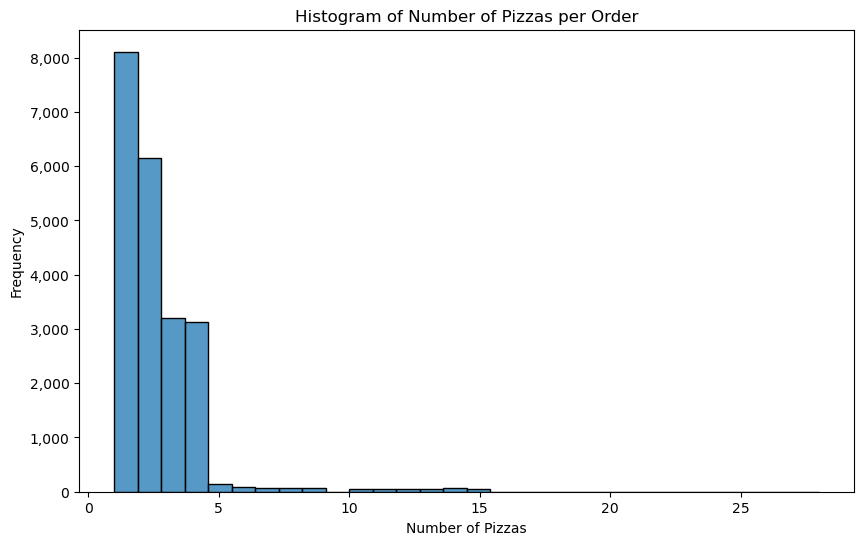

In [ ]:
# Histogram of number of pizzas per order.
plt.figure(figsize=(10, 6))
sns.histplot(df.groupby("order_id")["quantity"].sum(), bins=30, kde=False)
plt.title("Histogram of Number of Pizzas per Order")
plt.xlabel("Number of Pizzas")
plt.ylabel("Frequency")
# add thousand separator to y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [ ]:
# Get the number of orders where the quantity of pizzas is less than are equal to 4
num_orders_leq_4 = df.groupby("order_id")["quantity"].sum().le(4).sum()
print(f'Number of Orders with 4 or Fewer Pizzas: {num_orders_leq_4}')

# Get the percentage of orders where the quantity of pizzas is less than or equal to 4.
total_orders = df["order_id"].nunique()
percentage_leq_4 = (num_orders_leq_4 / total_orders) * 100
print(f'Percentage of Orders with 4 or Fewer Pizzas: {percentage_leq_4:.1f}%')

# Calculate the number of orders where the quantity of pizzas is exactly 1, 2, 3, and 4 and calculate the percentages.
num_orders_list = [1,2,3,4]
for num in num_orders_list:
    num_orders = df.groupby("order_id")["quantity"].sum().eq(num).sum()
    percentage = (num_orders / total_orders) * 100
    print(f'Number of Orders with {num} Pizza(s): {num_orders} ({percentage:.1f}%)')

Number of Orders with 4 or Fewer Pizzas: 20592
Percentage of Orders with 4 or Fewer Pizzas: 96.4%
Number of Orders with 1 Pizza(s): 8111 (38.0%)
Number of Orders with 2 Pizza(s): 6152 (28.8%)
Number of Orders with 3 Pizza(s): 3207 (15.0%)
Number of Orders with 4 Pizza(s): 3122 (14.6%)


In [ ]:
# Get the distribution of order quantities. Observe that the vast majority of orders are for 1 or 2 pizzas.
df["quantity"].value_counts().sort_index()

quantity
1    47693
2      903
3       21
4        3
Name: count, dtype: int64

In [ ]:
# Verify that resampling by day and summing the "quantity" column gives the correct total number of pizzas ordered.
# Observe that the Pandas resample function needs to be applied correctly so that we are summing the "quantity" column, not just counting rows.
# The consequence of doing this incorrectly is that orders with quantity > 1 will be undercounted.
wrong = df.resample("D").size()                 # counts rows only
correct = df["quantity"].resample("D").sum()    # sums the "quantity" column

comparison = pd.DataFrame({
    "row_count": wrong,
    "quantity_sum": correct
})

print(comparison.sum())

row_count       48620
quantity_sum    49574
dtype: int64


In [ ]:
# Notice that the row_count column has a lower total than the quantity_sum column, indicating that some orders had quantity > 1.
comparison.head(10)

,row_count,quantity_sum
order_datetime,,
2015-01-01,161,162
2015-01-02,188,191
2015-01-03,99,99
2015-01-04,133,135
2015-01-05,152,154
2015-01-06,180,184
2015-01-07,134,137
2015-01-08,150,154
2015-01-09,143,146


To simplify DataFrame operations moving forward, the code below expands the rows of the existing DataFrame where the quantity > 1 (i.e., quantity = 2, 3, or 4).

In [ ]:
# Reset the index to make "order_datetime" a column again. This step is necessary for the next operation to work.
df = df.reset_index()

# Expand rows where quantity > 1 so that each pizza ordered contributes to each row the dataframe.
df_expanded = df.loc[df.index.repeat(df["quantity"])].reset_index(drop=True)

# Set the 'quantity' column to 1 for all duplicated rows.
df_expanded['quantity'] = 1

# Set the index to "order_datetime" again.
df_expanded = df_expanded.set_index("order_datetime").sort_index()

In [ ]:
# 3. total number of pizzas (what expansion should produce)
total_pizzas = df["quantity"].sum()
print("Total number of pizzas ordered (after expanding rows where quantity > 1):", total_pizzas)
print("Expansion factor:", round(total_pizzas / df.shape[0], 3))
print("Expanded shape:", df_expanded.shape)   # should equal (total_pizzas, n_cols)

Total number of pizzas ordered (after expanding rows where quantity > 1): 49574
Expansion factor: 1.02
Expanded shape: (49574, 13)


In [ ]:
# Display basic information about the expanded dataframe and verify the number of observations.
df_expanded.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49574 entries, 2015-01-01 11:38:36 to 2015-12-31 23:02:05
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   pizza_id           49574 non-null  int64         
 1   order_id           49574 non-null  int64         
 2   pizza_name_id      49574 non-null  object        
 3   quantity           49574 non-null  int64         
 4   order_date         49574 non-null  datetime64[ns]
 5   order_time         49574 non-null  object        
 6   unit_price         49574 non-null  float64       
 7   total_price        49574 non-null  float64       
 8   pizza_size         49574 non-null  category      
 9   pizza_category     49574 non-null  object        
 10  pizza_ingredients  49574 non-null  object        
 11  pizza_name         49574 non-null  object        
 12  weekday            49574 non-null  category      
dtypes: category(2), datetime64

In [ ]:
# Count the number of pizzas ordered by pizza category.
df_expanded["pizza_category"].value_counts()

pizza_category
Classic    14888
Supreme    11987
Veggie     11649
Chicken    11050
Name: count, dtype: int64

In [ ]:
# Count the number of pizzas ordered by pizza name and category.
df_expanded[["pizza_name", "pizza_category"]].value_counts()

pizza_name                                  pizza_category
The Classic Deluxe Pizza                    Classic           2453
The Barbecue Chicken Pizza                  Chicken           2432
The Hawaiian Pizza                          Classic           2422
The Pepperoni Pizza                         Classic           2418
The Thai Chicken Pizza                      Chicken           2371
The California Chicken Pizza                Chicken           2370
The Sicilian Pizza                          Supreme           1938
The Spicy Italian Pizza                     Supreme           1924
The Southwest Chicken Pizza                 Chicken           1917
The Big Meat Pizza                          Classic           1914
The Four Cheese Pizza                       Veggie            1902
The Italian Supreme Pizza                   Supreme           1884
The Vegetables + Vegetables Pizza           Veggie            1526
The Mexicana Pizza                          Veggie            1484
The

In [ ]:
# Descriptive statistics by pizza size and unit price.
price_summary = (
    df_expanded.groupby("pizza_size", observed=True)["unit_price"]
      .agg(["count", "mean", "std", "min", "max", "median"])
      .reset_index()
)

# Add a column for the percentage of total pizzas for each size.
price_summary["percent_of_total"] = round((price_summary["count"] / price_summary["count"].sum()) * 100, 2)

# Reorder columns for better readability.
price_summary = price_summary[["pizza_size", "count", "percent_of_total", "mean", "std", "min", "max", "median"]]
price_summary = price_summary.loc[:, ["pizza_size", "count", "percent_of_total", "mean", "std", "min", "max", "median"]] # alternate approach

price_summary

,pizza_size,count,percent_of_total,mean,std,min,max,median
0,S,14403,29.05,12.363848,2.256903,9.75,23.65,12.00
1,M,15635,31.54,15.950256,1.138328,12.50,16.75,16.25
2,L,18956,38.24,19.799467,1.522065,15.25,21.00,20.50
3,XL,552,1.11,25.500000,0.000000,25.50,25.50,25.50
4,XXL,28,0.06,35.950000,0.000000,35.95,35.95,35.95


In [ ]:
# Investigate the maximum value for a small sized pizza.
df[df["unit_price"] == 23.65]

,order_datetime,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,weekday
199,2015-01-02 13:39:45,4195,1863,brie_carre_s,1,2015-01-02,13:39:45,23.65,23.65,S,Supreme,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza,Friday
209,2015-01-02 14:18:56,4201,1866,brie_carre_s,1,2015-01-02,14:18:56,23.65,23.65,S,Supreme,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza,Friday
314,2015-01-02 19:48:51,4310,1917,brie_carre_s,1,2015-01-02,19:48:51,23.65,23.65,S,Supreme,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza,Friday
437,2015-01-03 20:49:00,8137,3574,brie_carre_s,1,2015-01-03,20:49:00,23.65,23.65,S,Supreme,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza,Saturday
709,2015-01-05 20:30:40,16430,7234,brie_carre_s,1,2015-01-05,20:30:40,23.65,23.65,S,Supreme,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48176,2015-12-27 17:39:57,48176,21167,brie_carre_s,1,2015-12-27,17:39:57,23.65,23.65,S,Supreme,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza,Sunday
48243,2015-12-28 15:39:02,48244,21198,brie_carre_s,1,2015-12-28,15:39:02,23.65,23.65,S,Supreme,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza,Monday
48320,2015-12-29 13:20:17,48311,21225,brie_carre_s,1,2015-12-29,13:20:17,23.65,23.65,S,Supreme,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza,Tuesday
48455,2015-12-31 12:09:59,48456,21282,brie_carre_s,1,2015-12-31,12:09:59,23.65,23.65,S,Supreme,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza,Thursday


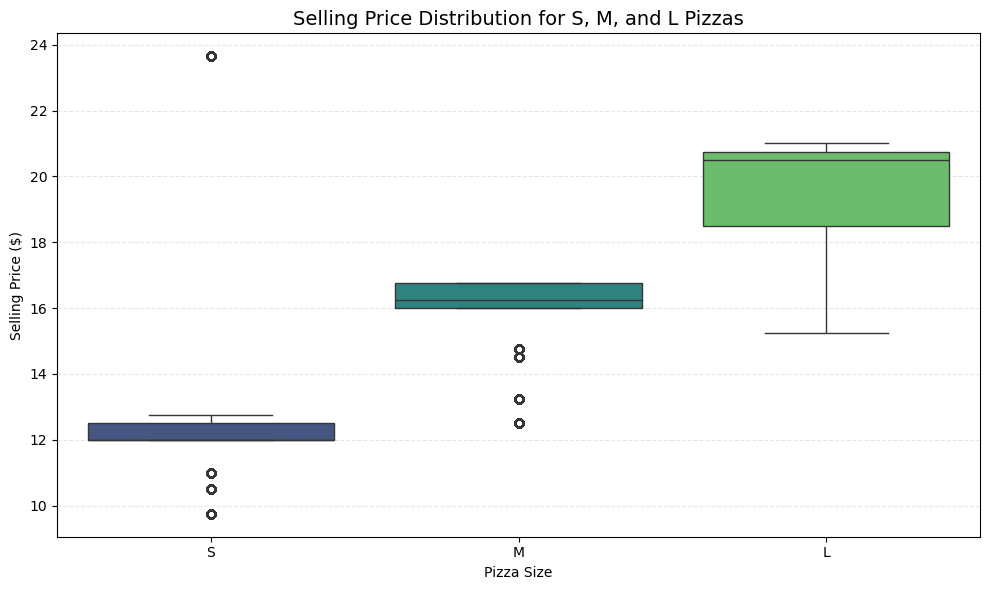

In [ ]:
# Filter only sizes with meaningful variation
sizes_to_plot = ["S", "M", "L"]

df_filtered = df_expanded[df_expanded["pizza_size"].isin(sizes_to_plot)].copy()
df_filtered["pizza_size"] = pd.Categorical(
    df_filtered["pizza_size"], 
    categories=sizes_to_plot, 
    ordered=True
)

plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df_filtered,
    x="pizza_size",
    y="unit_price",
    hue="pizza_size",          # required to use palette
    palette="viridis",
    dodge=False,               # keeps boxes aligned
    legend=False               # avoid duplicate legend
)

plt.title("Selling Price Distribution for S, M, and L Pizzas", fontsize=14)
plt.xlabel("Pizza Size")
plt.ylabel("Selling Price ($)")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

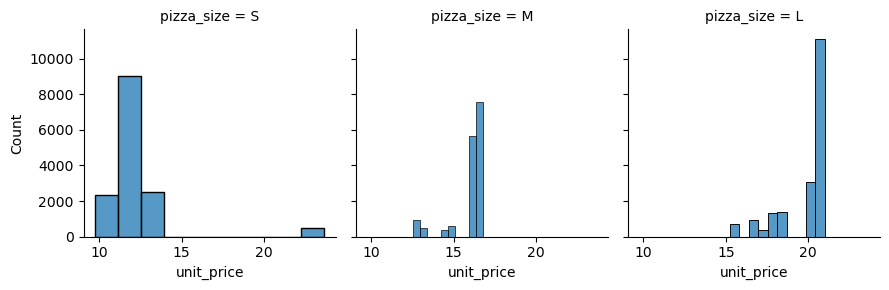

In [ ]:
# Histogram of unit prices by pizza size for S, M, and L sizes.
sns.FacetGrid(df_filtered, col="pizza_size", col_order=["S","M","L"]) \
   .map(sns.histplot, "unit_price", bins=10)

In [ ]:
cost_summary = price_summary.copy()
cost_summary["selling_price"] = cost_summary["median"]
cost_summary["production_cost"] = cost_summary["median"] * 0.3  # assuming 30% cost
cost_summary["cost_underage"] = cost_summary["selling_price"] - cost_summary["production_cost"]
cost_summary["salvage_value"] = np.zeros(len(cost_summary))  # assuming no salvage value
cost_summary["cost_overage"] = cost_summary["production_cost"] - cost_summary["salvage_value"]
cost_summary["critical_ratio"] = cost_summary["cost_underage"] / (cost_summary["cost_underage"] + cost_summary["cost_overage"])
cost_summary = cost_summary[["pizza_size", "selling_price", "production_cost", "cost_underage", "cost_overage", "critical_ratio"]]
cost_summary

,pizza_size,selling_price,production_cost,cost_underage,cost_overage,critical_ratio
0,S,12.00,3.600,8.400,3.600,0.7
1,M,16.25,4.875,11.375,4.875,0.7
2,L,20.50,6.150,14.350,6.150,0.7
3,XL,25.50,7.650,17.850,7.650,0.7
4,XXL,35.95,10.785,25.165,10.785,0.7


### Daily Pizza Demand

In [ ]:
# Use the resample function to get daily order quantities as a Series (sum of quantities, not just counts).
daily_orders = df_expanded["quantity"].resample("D").sum()

# Exclude the days with zero orders (dates with no orders) based on the assumption that the pizzeria was likely closed on those days.
daily_orders = daily_orders[daily_orders > 0]

# Convert to a DataFrame
daily = daily_orders.to_frame(name="daily_orders").reset_index()

# Rename column for clarity
daily.rename(columns={"order_datetime": "order_date"}, inplace=True)

# Add weekday name column
daily["weekday"] = daily["order_date"].dt.day_name()

# Convert weekday to ordered categorical
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_cat_dtype = pd.CategoricalDtype(categories=weekday_order, ordered=True)
daily["weekday"] = daily["weekday"].astype(weekday_cat_dtype)


In [ ]:
daily

,order_date,daily_orders,weekday
0,2015-01-01,162,Thursday
1,2015-01-02,191,Friday
2,2015-01-03,99,Saturday
3,2015-01-04,135,Sunday
4,2015-01-05,154,Monday
...,...,...,...
353,2015-12-27,89,Sunday
354,2015-12-28,102,Monday
355,2015-12-29,80,Tuesday
356,2015-12-30,82,Wednesday


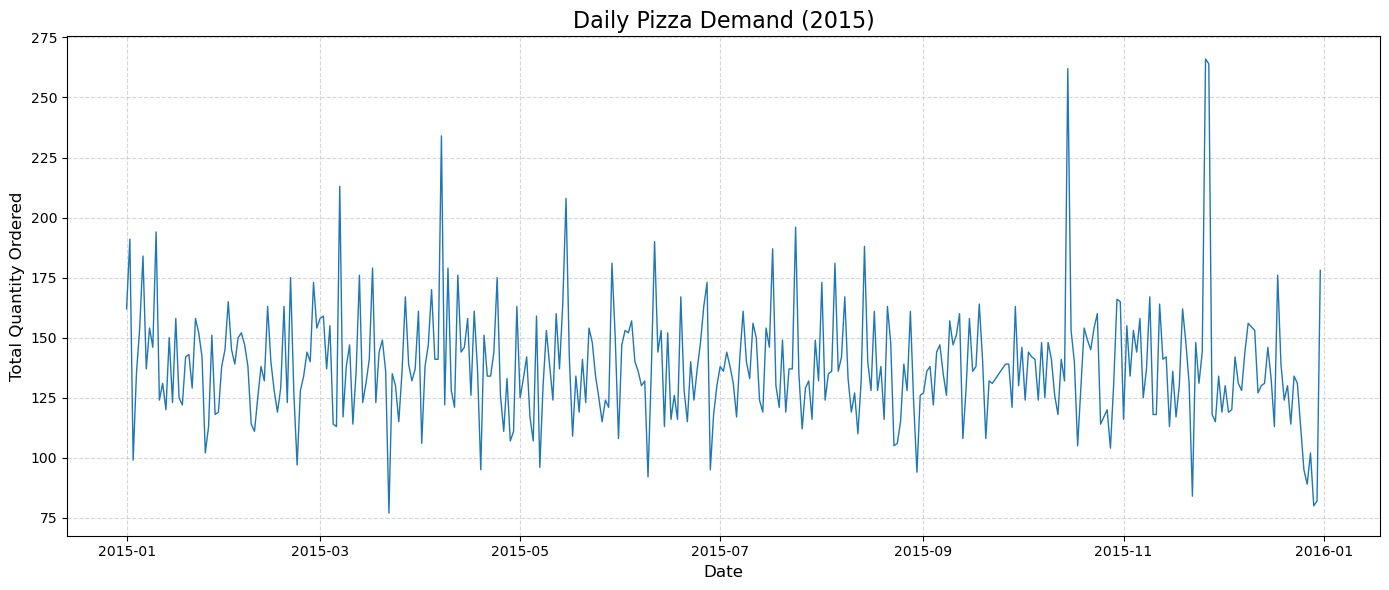

In [ ]:
# Plot daily pizza demand over the year 2015.
plt.figure(figsize=(14, 6))

plt.plot(daily["order_date"], daily["daily_orders"], linewidth=1)

plt.title("Daily Pizza Demand (2015)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Quantity Ordered", fontsize=12)

plt.grid(True, linestyle="--", alpha=0.5)

# Rotate date labels (if necessary) to prevent overlap
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
# Get some summary statistics on daily demand for pizzas.
print(daily["daily_orders"].describe().round(2))

count    358.00
mean     138.47
std       24.43
min       77.00
25%      124.00
50%      136.00
75%      150.00
max      266.00
Name: daily_orders, dtype: float64


In [ ]:
# Get the number and percentage of days where daily demand was between 100 and 175 pizzas.
num_days_in_range = daily["daily_orders"].between(100, 175).sum()
print(f'Number of Days with Daily Demand Between 100 and 175 Pizzas: {num_days_in_range}')

# Calculate the percentage of days in range.
percentage_in_range = (num_days_in_range / daily.shape[0]) * 100
print(f'Percentage of Days with Daily Demand Between 100 and 175 Pizzas: {percentage_in_range:.1f}%')

Number of Days with Daily Demand Between 100 and 175 Pizzas: 324
Percentage of Days with Daily Demand Between 100 and 175 Pizzas: 90.5%


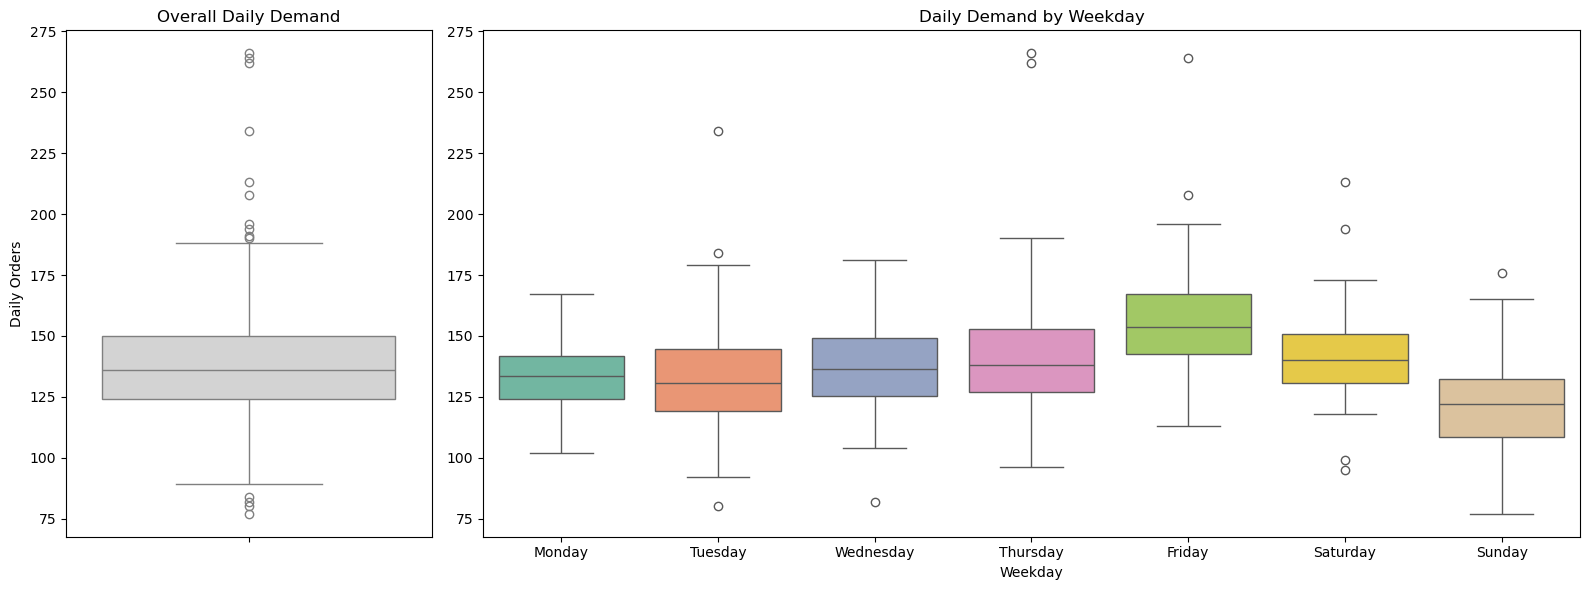

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 3]})

# Subplot 1 — Overall daily demand
sns.boxplot(y=daily["daily_orders"], ax=axes[0], color="lightgray")
axes[0].set_title("Overall Daily Demand")
axes[0].set_xlabel("")
axes[0].set_ylabel("Daily Orders")

# Subplot 2 — By weekday distribution
sns.boxplot(data=daily, x="weekday", y="daily_orders",
            hue="weekday", legend=False,  # required to use palette in future versions
            palette="Set2", ax=axes[1])

axes[1].set_title("Daily Demand by Weekday")
axes[1].set_xlabel("Weekday")
axes[1].set_ylabel("")

# Rotate weekday labels safely
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
# Note that the maximum daily demand for pizza occurred on Thanksgiving Day.
print(f'Maximum Daily Demand: {daily_orders.max()} ({daily_orders.idxmax().strftime("%Y-%m-%d")})')

Maximum Daily Demand: 266 (2015-11-26)


In [ ]:
# Note that there were several days with no orders where it is unclear whether the pizzeria was closed for business or not. 
# However, of the seven days with no orders, one was on Mother's Day (5/10/15), another was on the second day of Rosh Hashanah (9/24/15),
# and the other was on Christmas (12/25/15) when many businesses are often closed. Based on these observations, it is likely that the pizzeria
# was closed on the other dates and therefore they have been excluded from the daily demand analysis.
no_order_dates

['2015-05-10',
 '2015-09-24',
 '2015-09-25',
 '2015-10-19',
 '2015-10-26',
 '2015-12-10',
 '2015-12-25']

<Figure size 640x480 with 0 Axes>

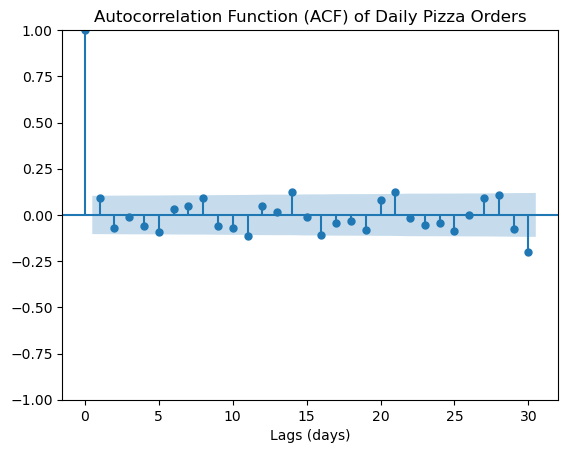

In [ ]:
# ACF plot for daily pizza orders
plt.figure()
plot_acf(daily_orders.values, lags=30)
plt.title("Autocorrelation Function (ACF) of Daily Pizza Orders")
plt.xlabel("Lags (days)")   
plt.show()

<Figure size 640x480 with 0 Axes>

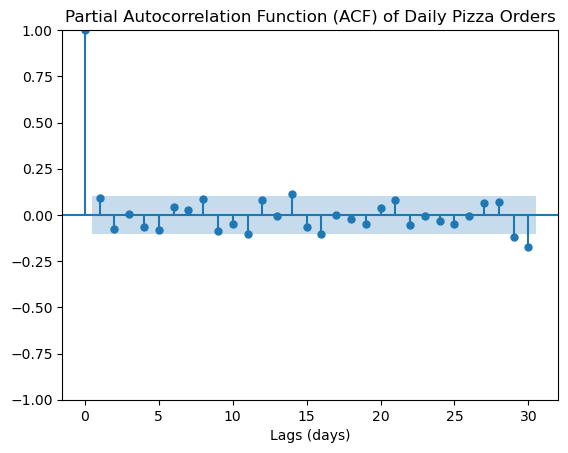

In [ ]:
# PACF plot for daily pizza orders
plt.figure()
plot_pacf(daily_orders.values, lags=30, method='ywm')
plt.title("Partial Autocorrelation Function (ACF) of Daily Pizza Orders")
plt.xlabel("Lags (days)")   
plt.show()

#### One-way ANOVA (Analysis of Variance)
- Null Hypothesis: mean daily demand is equal across all weekdays.
- Alternative Hypothesis: at least one weekday has a different mean.

**Interpretation**
- p < 0.05: reject null hypothesis -> means differ across weekdays.
- p > 0.05: fail to reject null hypothesis -> no evidence that they differ.

In [ ]:
# ANOVA to test for differences in mean daily orders by weekday.
groups = [group["daily_orders"].values for name, group in daily.groupby("weekday", observed=True)]

F, p = f_oneway(*groups)
print(f"ANOVA F={F:.4f}, p={p:.4e}")

if p < 0.05:
    print("Reject null hypothesis: at least one weekday has a different mean daily order quantity.")
else:
    print("Fail to reject null hypothesis: no significant difference in mean daily order quantity across weekdays.")

ANOVA F=12.5117, p=8.6557e-13
Reject null hypothesis: at least one weekday has a different mean daily order quantity.


#### Tukey's HSD (Honest Significant Difference) Test
A post hoc test used after a significant one-way ANOVA to determine which specific group means are different from one another. It is used when there are equal sample sizes for all groups and the goal is to perform pairwise comparisons while controlling the family-wise error rate. The test identifies the minimum difference required for two means to be considered statistically significant.

**Interpretation**
- p < 0.05: reject = True -> The two weekdays had significantly different mean demand.
- p > 0.05: reject = False -> no statistical evidence of a difference.

In [ ]:
# Make sure weekday is a string (not categorical)
daily['weekday_str'] = daily['weekday'].astype(str)

# Run Tukey HSD
tukey = pairwise_tukeyhsd(
    endog=daily["daily_orders"],        # dependent variable
    groups=daily["weekday_str"],        # group labels
    alpha=0.05                          # 95% confidence
)

# Create a DataFrame from Tukey HSD results.
tukey_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

# Save the DataFrame to a CSV file.
tukey_df.to_csv("tukey_hsd_results.csv", index=False)   

print(tukey)

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1    group2  meandiff p-adj   lower    upper   reject
-----------------------------------------------------------
  Friday    Monday    -23.5    0.0 -36.7625 -10.2375   True
  Friday  Saturday -14.7185 0.0169 -27.8528  -1.5841   True
  Friday    Sunday -35.6702    0.0 -48.8675 -22.4729   True
  Friday  Thursday -12.3369 0.0843 -25.5342   0.8605  False
  Friday   Tuesday   -22.93    0.0 -36.0644  -9.7956   True
  Friday Wednesday -21.4492    0.0 -34.5836  -8.3149   True
  Monday  Saturday   8.7815 0.4275  -4.3528  21.9159  False
  Monday    Sunday -12.1702 0.0928 -25.3675   1.0271  False
  Monday  Thursday  11.1631 0.1594  -2.0342  24.3605  False
  Monday   Tuesday     0.57    1.0 -12.5644  13.7044  False
  Monday Wednesday   2.0508 0.9993 -11.0836  15.1851  False
Saturday    Sunday -20.9517 0.0001 -34.0203  -7.8832   True
Saturday  Thursday   2.3816 0.9982  -10.687  15.4502  False
Saturday   Tuesday  -8.2115    0.5 -21.2

In [ ]:
# Summary statistics of daily orders by weekday.
daily.groupby("weekday", observed=True)["daily_orders"].describe()

,count,mean,std,min,25%,50%,75%,max
weekday,,,,,,,,
Monday,50.0,133.680000,14.270621,102.0,124.25,133.5,141.75,167.0
Tuesday,52.0,134.250000,23.912319,80.0,119.00,130.5,144.50,234.0
Wednesday,52.0,135.730769,17.857953,82.0,125.50,136.5,149.25,181.0
Thursday,51.0,144.843137,30.500080,96.0,127.00,138.0,153.00,266.0
Friday,50.0,157.180000,25.873073,113.0,142.50,153.5,167.00,264.0
Saturday,52.0,142.461538,20.204311,95.0,130.75,140.0,150.75,213.0
Sunday,51.0,121.509804,19.984366,77.0,108.50,122.0,132.50,176.0


In [ ]:
print(daily['daily_orders'].mean())
print(daily['daily_orders'].std())

138.47486033519553
24.4286690269572


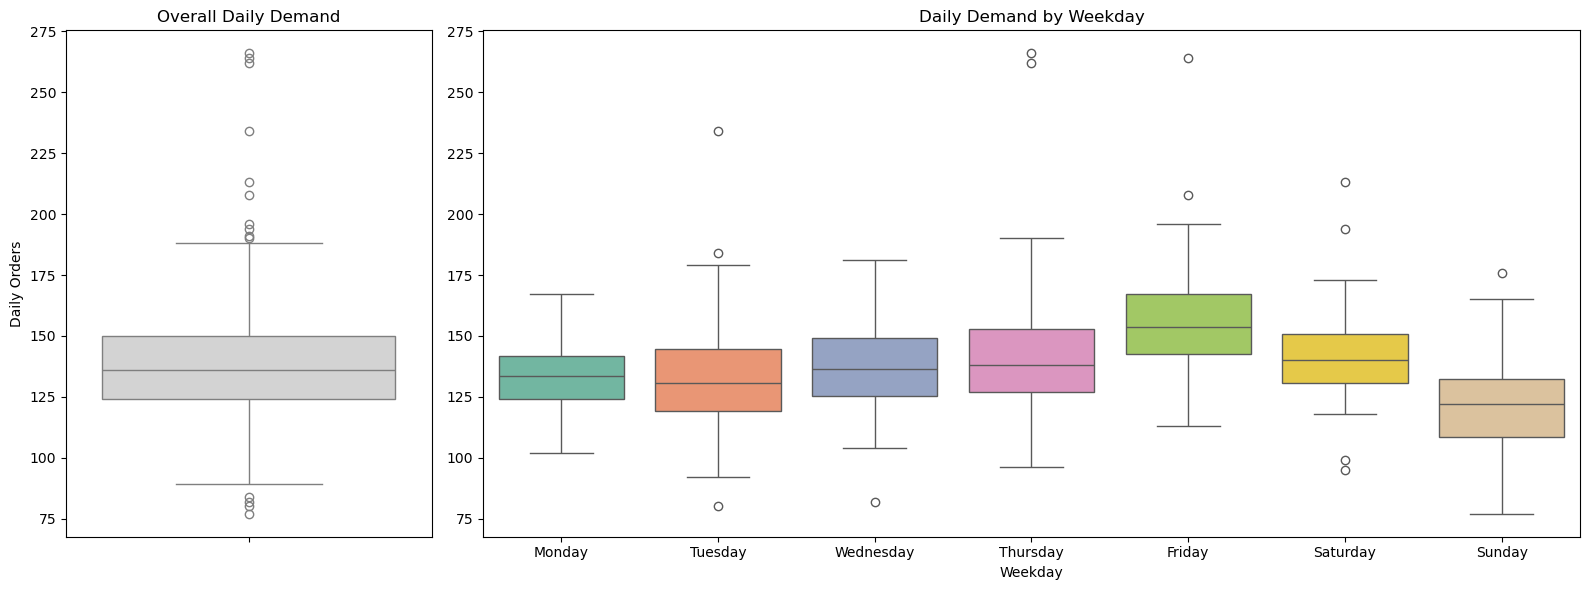

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 3]})

# Subplot 1 — Overall daily demand
sns.boxplot(y=daily["daily_orders"], ax=axes[0], color="lightgray")
axes[0].set_title("Overall Daily Demand")
axes[0].set_xlabel("")
axes[0].set_ylabel("Daily Orders")

# Subplot 2 — By weekday distribution
sns.boxplot(data=daily, x="weekday", y="daily_orders",
            hue="weekday", legend=False,  # required to use palette in future versions
            palette="Set2", ax=axes[1])

axes[1].set_title("Daily Demand by Weekday")
axes[1].set_xlabel("Weekday")
axes[1].set_ylabel("")

# Rotate weekday labels safely
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


=== Processing Monday ===
n = 50
min = 102, median = 133.5, mean = 133.68
skew = 0.100


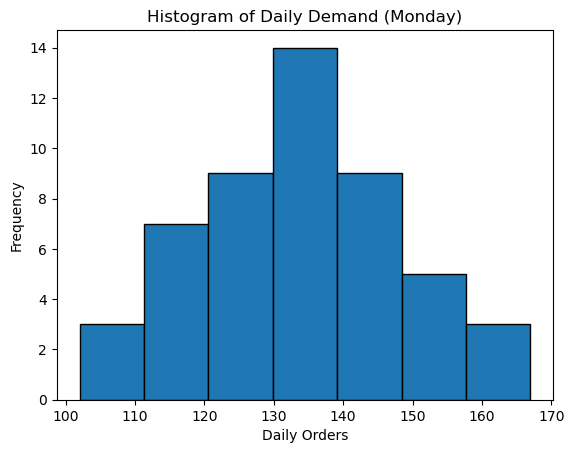

Arena file written: arena_inputs/monday_demand.txt

=== Processing Tuesday ===
n = 52
min = 80, median = 130.5, mean = 134.25
skew = 1.400


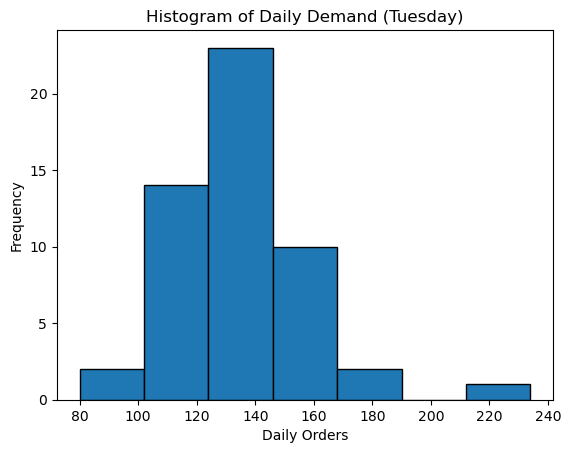

Arena file written: arena_inputs/tuesday_demand.txt

=== Processing Wednesday ===
n = 52
min = 82, median = 136.5, mean = 135.73
skew = -0.302


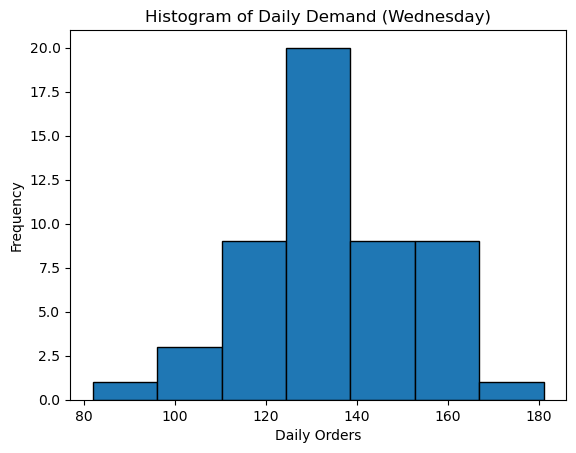

Arena file written: arena_inputs/wednesday_demand.txt

=== Processing Thursday ===
n = 51
min = 96, median = 138.0, mean = 144.84
skew = 2.315


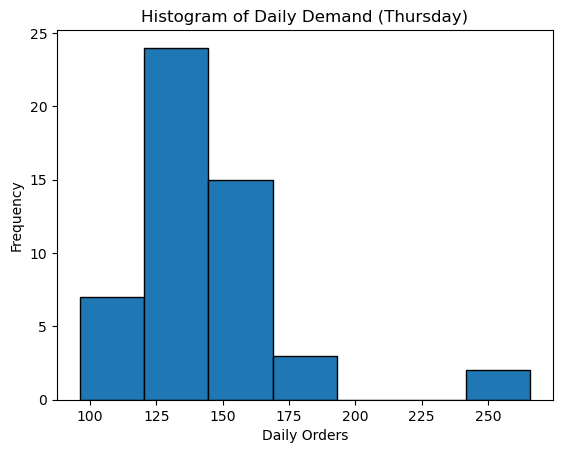

Arena file written: arena_inputs/thursday_demand.txt

=== Processing Friday ===
n = 50
min = 113, median = 153.5, mean = 157.18
skew = 1.419


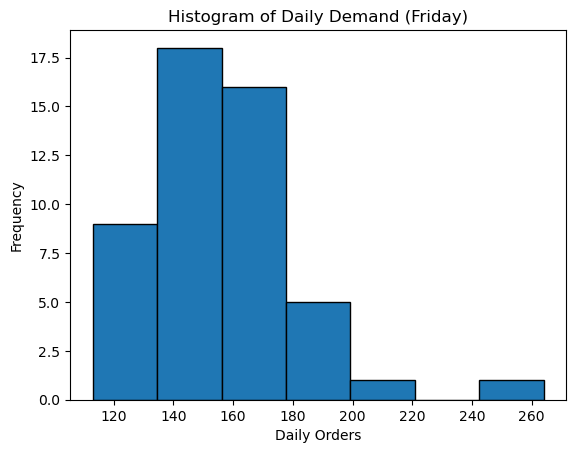

Arena file written: arena_inputs/friday_demand.txt

=== Processing Saturday ===
n = 52
min = 95, median = 140.0, mean = 142.46
skew = 0.841


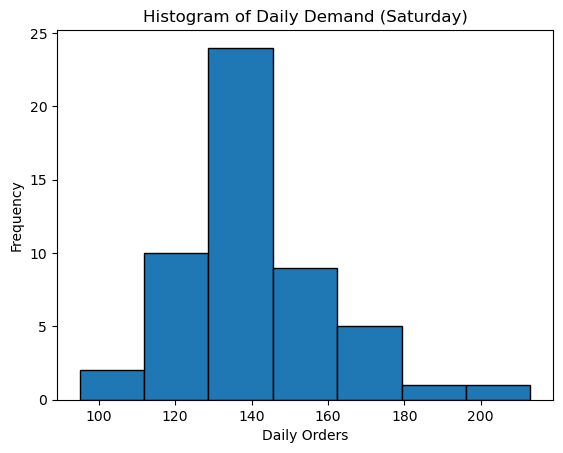

Arena file written: arena_inputs/saturday_demand.txt

=== Processing Sunday ===
n = 51
min = 77, median = 122.0, mean = 121.51
skew = 0.250


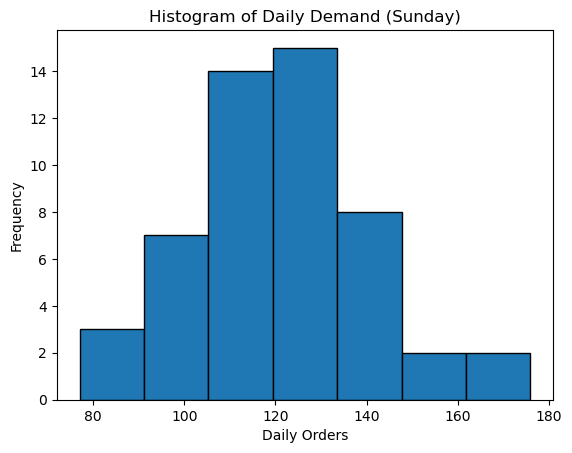

Arena file written: arena_inputs/sunday_demand.txt


In [ ]:
# Create output folder.
os.makedirs("arena_inputs", exist_ok=True)

# Weekdays in order.
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

for day in weekday_order:
    print(f"\n=== Processing {day} ===")

    # Extract daily orders for each weekday
    day_data = daily.loc[daily["weekday"] == day, "daily_orders"].values

    # Remove any NaNs (for safety)
    day_data = day_data[~np.isnan(day_data)]
    n = len(day_data)

    # Quick descriptive checks
    print(f"n = {n}")
    print(f"min = {day_data.min()}, median = {np.median(day_data)}, mean = {day_data.mean():.2f}")
    print(f"skew = {stats.skew(day_data):.3f}")

    # Generate histogram 
    plt.hist(day_data, bins=7, edgecolor="black")
    plt.title(f"Histogram of Daily Demand ({day})")
    plt.xlabel("Daily Orders")
    plt.ylabel("Frequency")
    plt.show()

    # Save Arena-compatible text file
    filename = f"arena_inputs/{day.lower()}_demand.txt"
    with open(filename, "w") as f:
        for val in day_data:
            f.write(f"{int(val)}\n")   # ensures integers

    print(f"Arena file written: {filename}")



=== Processing Overall Daily Demand ===
n = 358
min = 77, median = 136.0, mean = 138.47
skew = 1.383


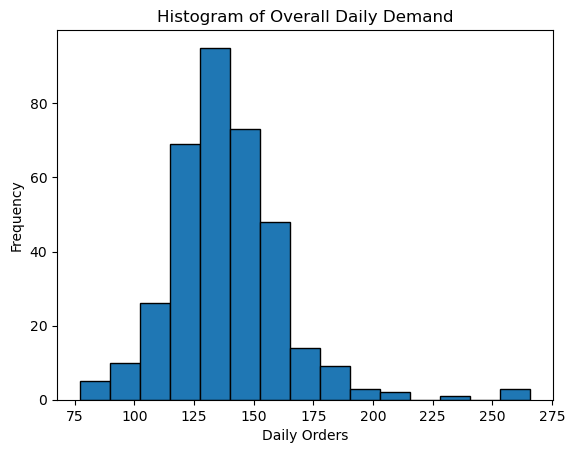

Arena file written: arena_inputs/overall_daily_demand.txt


In [ ]:
# Create text file for overall daily demand for analysis using Arena's Input Analyzer.
filename = "arena_inputs/overall_daily_demand.txt"
day_data = daily["daily_orders"].values
n = len(day_data)
print(f"\n=== Processing Overall Daily Demand ===")
print(f"n = {n}")   
print(f"min = {day_data.min()}, median = {np.median(day_data)}, mean = {day_data.mean():.2f}")
print(f"skew = {stats.skew(day_data):.3f}")

# Generate histogram
plt.hist(day_data, bins=15, edgecolor="black")
plt.title("Histogram of Overall Daily Demand")
plt.xlabel("Daily Orders")
plt.ylabel("Frequency")
plt.show()

# Save Arena-compatible text file
with open(filename, "w") as f:
    for val in day_data:
        f.write(f"{int(val)}\n")   # ensures integers

print(f"Arena file written: {filename}")

### Arena Software Instructions

The text files created with the code above can be analyzed using Arena's Input Analyzer using the following procedure:
1. Open Arena
2. Navigate to Tools
3. Click on Input Analyzer in Analysis
4. Under File click New
5. Under File click Data File and choose Use Existing...
6. Select the appropriate .txt file with pizza demand data for a particular weekday
7. Inspect the distribution and data summary
8. Under Fit click Fit All
9. Save appropriate files





## Monte Carlo Simulation

In [ ]:
# ---------------------------
# Inputs
# ---------------------------

# Newsvendor & simulation parameters  (edit these as needed depending on the analysis)
price = 20.50         # selling price per Large pizza (used median price)
cost = 6.15           # cost per Large pizza (i.e., food cost = 30% -> price*0.30)
salvage = 0.0         # salvage value per leftover pizza (salvage = 0)
CR = 0.70             # critical ratio 
n_years = 1           # how many years to simulate per replication
days_per_year = 365
replications = 2000   # number of Monte Carlo replications 
seed = 6644

# ---------------------------
# Compute Q* per weekday using Normal inverse CDF
# ---------------------------

# Compute z-value once
z = stats.norm.ppf(CR)

# Compute daily demand mean & std by weekday
weekday_stats = (
    daily.groupby("weekday", observed=True)["daily_orders"]
         .agg(["mean", "std"])
         .reset_index()
)

# Compute Q* for each weekday
weekday_stats["Q_star"] = weekday_stats["mean"] + z * weekday_stats["std"]

# Reformat DataFrame
weekday_stats = weekday_stats.rename(columns={"mean": "mu", "std": "sigma"})
weekday_stats = weekday_stats[["weekday", "mu", "sigma", "Q_star"]].round(2)
print("Weekday Q* table:\n", weekday_stats)

# ---------------------------
# Evaluate a few alternative inventory policies: Q* + offsets (e.g., -20, -10, 0, +10, +20)
# ---------------------------
# Define offsets
offsets = [-20, -10, 0, 10, 20]

rng = np.random.default_rng(42)

summary_tables, raw_samples = nv.simulate_many_reps_with_offsets(weekday_stats, price, cost, salvage, offsets=offsets, days_per_year=365, replications=replications, rng=rng)

for key, table in summary_tables.items():
    df = pd.DataFrame(table).copy()

    # tidy numeric output
    df[["Mean", "CI Lower (95%)", "CI Upper (95%)"]] = \
        df[["Mean", "CI Lower (95%)", "CI Upper (95%)"]].round(2)

    print(f"\nOffset: {key}")
    print(df.to_string(index=False))

Weekday Q* table:
      weekday      mu  sigma  Q_star
0     Monday  133.68  14.27  141.16
1    Tuesday  134.25  23.91  146.79
2  Wednesday  135.73  17.86  145.10
3   Thursday  144.84  30.50  160.84
4     Friday  157.18  25.87  170.75
5   Saturday  142.46  20.20  153.06
6     Sunday  121.51  19.98  131.99

Offset: -20
          Metric      Mean  CI Lower (95%)  CI Upper (95%)
   Annual Profit 639965.46       639788.47       640142.46
   Stockout Rate      0.67            0.67            0.67
Leftover per Day      5.06            5.03            5.08
       Fill Rate      0.90            0.90            0.90

Offset: -10
          Metric      Mean  CI Lower (95%)  CI Upper (95%)
   Annual Profit 661463.80       661233.09       661694.52
   Stockout Rate      0.48            0.48            0.49
Leftover per Day      9.18            9.15            9.21
       Fill Rate      0.94            0.94            0.94

Offset: 0
          Metric      Mean  CI Lower (95%)  CI Upper (95%)
   Annu

In [ ]:
summary_tables.values()

dict_values([             Metric           Mean  CI Lower (95%)  CI Upper (95%)
0     Annual Profit  639965.463750   639788.470638   640142.456862
1     Stockout Rate       0.667319        0.666278        0.668360
2  Leftover per Day       5.055541        5.031887        5.079195
3         Fill Rate       0.897849        0.897623        0.898075,              Metric           Mean  CI Lower (95%)  CI Upper (95%)
0     Annual Profit  661463.803500   661233.090489   661694.516511
1     Stockout Rate       0.484023        0.482880        0.485166
2  Leftover per Day       9.182392        9.151558        9.213225
3         Fill Rate       0.940107        0.939917        0.940297,              Metric           Mean  CI Lower (95%)  CI Upper (95%)
0     Annual Profit  668946.149750   668667.705216   669224.594284
1     Stockout Rate       0.300156        0.299112        0.301200
2  Leftover per Day      15.182412       15.145200       15.219625
3         Fill Rate       0.968912        0.968

In [ ]:
# Combine summary_tables results for policy offsets into a single DataFrame and save to CSV.
combined_tables = []

for offset, table in summary_tables.items():
    t = table.copy()
    t["Offset"] = offset
    combined_tables.append(t)

combined_df = pd.concat(combined_tables, ignore_index=True)

combined_df.to_csv("policy_offset_performance_summary.csv", index=False)
print("Saved: policy_offset_performance_summary.csv")


Saved: policy_offset_performance_summary.csv


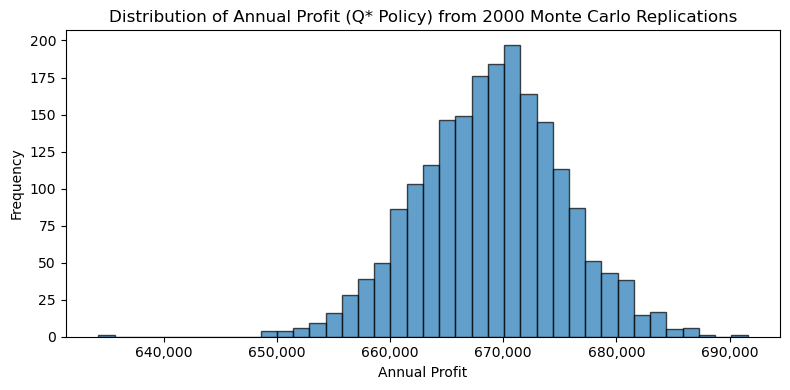


 Summary of Q* Inventory Policy Performance:

          Metric      Mean  CI Lower (95%)  CI Upper (95%)
   Annual Profit 668946.15       668667.71       669224.59
   Stockout Rate      0.30            0.30            0.30
Leftover per Day     15.18           15.15           15.22
       Fill Rate      0.97            0.97            0.97


In [ ]:
# Extract the table and profit samples for offset = 0
qstar_results = summary_tables[0]  # summary table
qstar_profit = raw_samples[0]['profit']  # raw simulation outcomes

# ---------------------------
# Plot: Distribution of Annual Profit (Q* Policy)
# ---------------------------
plt.figure(figsize=(8,4))
plt.hist(qstar_profit, bins=40, edgecolor='k', alpha=0.7)

plt.title(f"Distribution of Annual Profit (Q* Policy) from {replications} Monte Carlo Replications")

plt.xlabel("Annual Profit")
plt.ylabel("Frequency")

# Format x-axis ticks with commas
plt.gca().xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: f"{int(x):,}")
)

plt.tight_layout()
plt.show()

# ---------------------------
# Print Summary Table
# ---------------------------
print("\n Summary of Q* Inventory Policy Performance:\n")
print(pd.DataFrame(qstar_results).round(2).to_string(index=False))

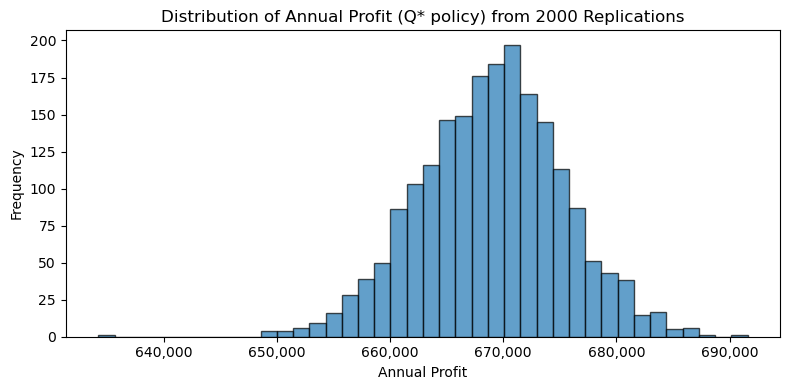

In [ ]:
# ---------------------------
# Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.hist(qstar_profit, bins=40, edgecolor='k', alpha=0.7)

plt.title(f'Distribution of Annual Profit (Q* policy) from {replications} Replications')

plt.xlabel('Annual Profit')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}")) # Add thousands separators to x-axis
plt.tight_layout()
plt.show()